# Extended ITS Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

## Read Data

In [2]:
''' Read Data - Choose ONE of the following datasets '''

# Travel Distance per trip: LAD
# file = 'mobility indicators/daily_alltrips_duration_distance_GLAresidence_homearea_pertrip/mean_distance_lad_merge_result.csv'
# area_key = 'LAD22CD'
# use_col = 'GLA'
# output_filename = 'Travel Distance LAD'

# Travel Distance per trip: MSOA
file = 'mobility indicators/daily_alltrips_duration_distance_GLAresidence_homearea_pertrip/mean_distance_msoa_merge_result.csv'
area_key = 'MSOA21CD'
use_col = 'GLA'
output_filename = 'Travel Distance MSOA'

# Casual Activity Count: LAD
# file = 'mobility indicators/daily_count_casual_activities/merge_result_lad.csv'
# area_key = 'LAD22CD'
# use_col = 'activity_count'
# output_filename = 'Casual Activity Count LAD'

# Casual Activity Count: MSOA
# file = 'mobility indicators/daily_count_casual_activities/merge_result_msoa.csv'
# area_key = 'MSOA21CD'
# use_col = 'activity_count'
# output_filename = 'Casual Activity Count MSOA'

# Commuting Duration per capita: LAD
# file = 'mobility indicators/daily_commuting_duration_distance/mean_duration_distance_lad_merge_result.csv'
# area_key = 'LAD22CD'
# use_col = 'duration_minutes'
# output_filename = 'Commuting Duration LAD'

# Commuting Duration per capita: MSOA
# file = 'mobility indicators/daily_commuting_duration_distance/mean_duration_distance_msoa_merge_result.csv'
# area_key = 'MSOA21CD'
# use_col = 'duration_minutes'
# output_filename = 'Commuting Duration MSOA'

In [3]:
''' Read Data '''

data = pd.read_csv(file)
data.rename(columns={use_col: 'count'}, inplace=True)
folder_name = file.split('/')[1]

# Convert 'day' to datetime
data['day'] = pd.to_datetime(data['day'])

# select data before 2021-12-12, remove Christmas
data = data[data['day'] < ('2021-12-12')]
data = data.groupby(['day', area_key]).agg({'count': 'mean'}).reset_index()

# Create a binary indicator for the intervention (1 if on or after Oct 25, 2021, else 0)
intervention_date = pd.to_datetime('2021-10-25')
data['intervention'] = (data['day'] >= intervention_date).astype(int)

# Create time variables (number of hours since the start of the dataset)
data['time1'] = (data['day'] - data['day'].min()).dt.total_seconds() / (60 * 60 * 24)
data['time2'] = (data['day'] - intervention_date).dt.total_seconds() / (60 * 60 * 24)
data.loc[data['time2'] < 0, 'time2'] = 0

# Create Day of Week (dow) categorical variable
data['dow'] = data['day'].dt.dayofweek
day_of_week_dummies = pd.get_dummies(data['dow'], prefix='dow', drop_first=True).astype(int)
data = pd.concat([data, day_of_week_dummies], axis=1)
data.drop(columns=['dow'], inplace=True)

data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2021-10-01,E02000001,4217.592031,0,0.0,0.0,0,0,0,1,0,0
1,2021-10-01,E02000002,3052.038883,0,0.0,0.0,0,0,0,1,0,0
2,2021-10-01,E02000003,4271.400031,0,0.0,0.0,0,0,0,1,0,0
3,2021-10-01,E02000004,3316.678252,0,0.0,0.0,0,0,0,1,0,0
4,2021-10-01,E02000005,2820.681639,0,0.0,0.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72139,2021-12-11,E02007111,3825.484783,1,71.0,47.0,0,0,0,0,1,0
72140,2021-12-11,E02007112,3952.935414,1,71.0,47.0,0,0,0,0,1,0
72141,2021-12-11,E02007113,4513.575395,1,71.0,47.0,0,0,0,0,1,0
72142,2021-12-11,E02007114,4052.152848,1,71.0,47.0,0,0,0,0,1,0


In [4]:
# remove outliers: City of London

''' LAD '''
# data = data[data['LAD22CD'] != 'E09000001']
# data

''' MSOA '''
data = data[data['MSOA21CD'] != 'E02000001']
data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
1,2021-10-01,E02000002,3052.038883,0,0.0,0.0,0,0,0,1,0,0
2,2021-10-01,E02000003,4271.400031,0,0.0,0.0,0,0,0,1,0,0
3,2021-10-01,E02000004,3316.678252,0,0.0,0.0,0,0,0,1,0,0
4,2021-10-01,E02000005,2820.681639,0,0.0,0.0,0,0,0,1,0,0
5,2021-10-01,E02000007,2999.628000,0,0.0,0.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
72139,2021-12-11,E02007111,3825.484783,1,71.0,47.0,0,0,0,0,1,0
72140,2021-12-11,E02007112,3952.935414,1,71.0,47.0,0,0,0,0,1,0
72141,2021-12-11,E02007113,4513.575395,1,71.0,47.0,0,0,0,0,1,0
72142,2021-12-11,E02007114,4052.152848,1,71.0,47.0,0,0,0,0,1,0


In [5]:
# Read Census Data

''' LAD level '''
"""
# rden: residence density, TS0006
rden = pd.read_csv('Census Data/census2021-ts006-ltla.csv').iloc[:, 2:]
rden.columns = ['LAD22CD', 'Rden']
data = data.merge(rden, on='LAD22CD', how='left')

# age: average age, TS0007
# age = pd.read_csv('Census Data/census2021-ts007-ltla.csv')

# Sfem: Share of femal, TS0008
sfem = pd.read_csv('Census Data/census2021-ts008-ltla.csv').iloc[:, 2:]
sfem['Sfem'] = sfem['Sex: Female; measures: Value'] / sfem['Sex: All persons; measures: Value']
sfem = sfem[['geography code', 'Sfem']]
sfem.columns = ['LAD22CD', 'Sfem']
data = data.merge(sfem, on='LAD22CD', how='left')

# Hedu: Higher education, TS0067
hedu = pd.read_csv('Census Data/census2021-ts067-ltla.csv')
hedu['Hedu'] = hedu['Highest level of qualification: Level 4 qualifications and above'] / hedu['Highest level of qualification: Total: All usual residents aged 16 years and over']
hedu = hedu[['geography code', 'Hedu']]
hedu.columns = ['LAD22CD', 'Hedu']
data = data.merge(hedu, on='LAD22CD', how='left')

# Scar: Share of car ownership, TS0045
scar = pd.read_csv('Census Data/census2021-ts045-ltla.csv').iloc[:, 2:]
scar['Scar'] = (scar['Number of cars or vans: Total: All households'] - scar['Number of cars or vans: No cars or vans in household']) / scar['Number of cars or vans: Total: All households']
scar = scar[['geography code', 'Scar']]
scar.columns = ['LAD22CD', 'Scar']
data = data.merge(scar, on='LAD22CD', how='left')

# DistWork: Distance to work, TS0058
# distwork = pd.read_csv('Census Data/census2021-ts058-ltla.csv').iloc[:, 2:]

# CarWork: Share of car to work, TS0061
carwork = pd.read_csv('Census Data/census2021-ts061-ltla.csv').iloc[:, 2:]
carwork['CarWork'] = carwork['Method of travel to workplace: Driving a car or van'] / carwork['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
carwork = carwork[['geography code', 'CarWork']]
carwork.columns = ['LAD22CD', 'CarWork']
data = data.merge(carwork, on='LAD22CD', how='left')

# Swfh: Share of working from home, TS0061
swfh = pd.read_csv('Census Data/census2021-ts061-ltla.csv').iloc[:, 2:]
swfh['Swfh'] = swfh['Method of travel to workplace: Work mainly at or from home'] / swfh['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
swfh = swfh[['geography code', 'Swfh']]
swfh.columns = ['LAD22CD', 'Swfh']
data = data.merge(swfh, on='LAD22CD', how='left')

# Income: GDHI
gdhi = pd.read_csv('Census Data/income_GDHI2021_LondonLAD.csv', usecols=['mnemonic', 'GDHI per head index (UK = 100)'])
gdhi.columns = ['LAD22CD', 'Income']
data = data.merge(gdhi, on='LAD22CD', how='left')

# PTAL: Public Transport Accessibility Level
ptal = pd.read_csv('PTAL/LAD2022 AvPTAI2015.csv')
ptal.columns = ['LAD22CD', 'PTAL']
data = data.merge(ptal, on='LAD22CD', how='left')

social_vars = ['Rden', 'Sfem', 'Hedu', 'Scar', 'CarWork', 'Swfh', 'Income', 'PTAL']
"""


''' MSOA level '''
# """
# rden: residence density, TS0006
rden = pd.read_csv('Census Data/census2021-ts006-msoa.csv').iloc[:, 2:]
rden.columns = ['MSOA21CD', 'Rden']
data = data.merge(rden, on='MSOA21CD', how='left')

# age: average age, TS0007
# age = pd.read_csv('Census Data/census2021-ts007-msoa.csv')

# Sfem: Share of femal, TS0008
sfem = pd.read_csv('Census Data/census2021-ts008-msoa.csv').iloc[:, 2:]
sfem['Sfem'] = sfem['Sex: Female; measures: Value'] / sfem['Sex: All persons; measures: Value']
sfem = sfem[['geography code', 'Sfem']]
sfem.columns = ['MSOA21CD', 'Sfem']
data = data.merge(sfem, on='MSOA21CD', how='left')

# Hedu: Higher education, TS0067
hedu = pd.read_csv('Census Data/census2021-ts067-msoa.csv')
hedu['Hedu'] = hedu['Highest level of qualification: Level 4 qualifications and above'] / hedu['Highest level of qualification: Total: All usual residents aged 16 years and over']
hedu = hedu[['geography code', 'Hedu']]
hedu.columns = ['MSOA21CD', 'Hedu']
data = data.merge(hedu, on='MSOA21CD', how='left')

# Scar: Share of car ownership, TS0045
scar = pd.read_csv('Census Data/census2021-ts045-msoa.csv').iloc[:, 2:]
scar['Scar'] = (scar['Number of cars or vans: Total: All households'] - scar['Number of cars or vans: No cars or vans in household']) / scar['Number of cars or vans: Total: All households']
scar = scar[['geography code', 'Scar']]
scar.columns = ['MSOA21CD', 'Scar']
data = data.merge(scar, on='MSOA21CD', how='left')

# DistWork: Distance to work, TS0058
# distwork = pd.read_csv('Census Data/census2021-ts058-msoa.csv').iloc[:, 2:]

# CarWork: Share of car to work, TS0061
carwork = pd.read_csv('Census Data/census2021-ts061-msoa.csv').iloc[:, 2:]
carwork['CarWork'] = carwork['Method of travel to workplace: Driving a car or van'] / carwork['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
carwork = carwork[['geography code', 'CarWork']]
carwork.columns = ['MSOA21CD', 'CarWork']
data = data.merge(carwork, on='MSOA21CD', how='left')

# Swfh: Share of working from home, TS0061
swfh = pd.read_csv('Census Data/census2021-ts061-msoa.csv').iloc[:, 2:]
swfh['Swfh'] = swfh['Method of travel to workplace: Work mainly at or from home'] / swfh['Method of travel to workplace: Total: All usual residents aged 16 years and over in employment the week before the census']
swfh = swfh[['geography code', 'Swfh']]
swfh.columns = ['MSOA21CD', 'Swfh']
data = data.merge(swfh, on='MSOA21CD', how='left')

# PTAL: Public Transport Accessibility Level
ptal = pd.read_csv('PTAL/MSOA2021 AvPTAI2015.csv')
ptal.columns = ['MSOA21CD', 'PTAI']
data = data.merge(ptal, on='MSOA21CD', how='left')

social_vars = ['Rden', 'Sfem', 'Hedu', 'Scar', 'CarWork', 'Swfh', 'PTAI']
# """

''' centering '''
for var in social_vars:
    data[f'{var}_centered'] = data[var] - data[var].mean()

# fillna
data.fillna(0, inplace=True)

data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,...,CarWork,Swfh,PTAI,Rden_centered,Sfem_centered,Hedu_centered,Scar_centered,CarWork_centered,Swfh_centered,PTAI_centered
0,2021-10-01,E02000002,3052.038883,0,0.0,0.0,0,0,0,1,...,0.390364,0.209389,3.731210,-5060.063237,0.011241,-0.158924,0.090805,0.179302,-0.207410,-9.819832
1,2021-10-01,E02000003,4271.400031,0,0.0,0.0,0,0,0,1,...,0.320351,0.255059,7.723008,-3501.363237,-0.010048,-0.127878,0.115125,0.109289,-0.161740,-5.828034
2,2021-10-01,E02000004,3316.678252,0,0.0,0.0,0,0,0,1,...,0.391779,0.250803,4.164166,-6227.463237,-0.004362,-0.160598,0.173672,0.180717,-0.165996,-9.386876
3,2021-10-01,E02000005,2820.681639,0,0.0,0.0,0,0,0,1,...,0.355821,0.220485,6.134339,436.436763,-0.002964,-0.130190,0.129228,0.144758,-0.196314,-7.416703
4,2021-10-01,E02000007,2999.628000,0,0.0,0.0,0,0,0,1,...,0.344803,0.186798,5.266994,-3036.663237,0.011161,-0.150993,0.035123,0.133741,-0.230001,-8.284047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72067,2021-12-11,E02007111,3825.484783,1,71.0,47.0,0,0,0,0,...,0.034812,0.629448,42.214395,312.236763,-0.020970,0.209927,-0.401807,-0.176251,0.212649,28.663354
72068,2021-12-11,E02007112,3952.935414,1,71.0,47.0,0,0,0,0,...,0.049000,0.681750,12.478780,6226.936763,-0.044609,0.236516,-0.360011,-0.162062,0.264951,-1.072262
72069,2021-12-11,E02007113,4513.575395,1,71.0,47.0,0,0,0,0,...,0.065438,0.596544,15.832084,1811.836763,-0.032327,0.157646,-0.295962,-0.145625,0.179745,2.281042
72070,2021-12-11,E02007114,4052.152848,1,71.0,47.0,0,0,0,0,...,0.072718,0.568014,13.968328,8507.736763,-0.019406,0.111075,-0.274435,-0.138344,0.151215,0.417286


In [6]:
# Read time series data: fuel price
# This data was excluded from final analysis due to multicollinearity.

''' Fuel weekly data '''
weekly_data = pd.read_csv('fuel price/weekly_fuel.csv')
weekly_data['Date'] = pd.to_datetime(weekly_data['Date'], format='%m/%d/%y')

# convert to daily data
daily_data = pd.DataFrame({
    'Date': pd.date_range(start='2021-09-27', end='2021-12-11', freq='D'),
    'fuel_price': 0  # 示例变量
})
daily_data = daily_data.merge(
    weekly_data.rename(columns={'Date': 'Weekly_Date'}),
    how='left',
    left_on='Date',
    right_on='Weekly_Date'
)
daily_data['fuel_price'] = daily_data['ULSP'].ffill()
daily_data = daily_data.drop(columns=['Weekly_Date', 'ULSP'])

data = data.merge(daily_data, left_on='day', right_on='Date', how='left')
data.drop(columns=['Date'], inplace=True)
data

,day,MSOA21CD,count,intervention,time1,time2,dow_1,dow_2,dow_3,dow_4,...,Swfh,PTAI,Rden_centered,Sfem_centered,Hedu_centered,Scar_centered,CarWork_centered,Swfh_centered,PTAI_centered,fuel_price
0,2021-10-01,E02000002,3052.038883,0,0.0,0.0,0,0,0,1,...,0.209389,3.731210,-5060.063237,0.011241,-0.158924,0.090805,0.179302,-0.207410,-9.819832,135.19
1,2021-10-01,E02000003,4271.400031,0,0.0,0.0,0,0,0,1,...,0.255059,7.723008,-3501.363237,-0.010048,-0.127878,0.115125,0.109289,-0.161740,-5.828034,135.19
2,2021-10-01,E02000004,3316.678252,0,0.0,0.0,0,0,0,1,...,0.250803,4.164166,-6227.463237,-0.004362,-0.160598,0.173672,0.180717,-0.165996,-9.386876,135.19
3,2021-10-01,E02000005,2820.681639,0,0.0,0.0,0,0,0,1,...,0.220485,6.134339,436.436763,-0.002964,-0.130190,0.129228,0.144758,-0.196314,-7.416703,135.19
4,2021-10-01,E02000007,2999.628000,0,0.0,0.0,0,0,0,1,...,0.186798,5.266994,-3036.663237,0.011161,-0.150993,0.035123,0.133741,-0.230001,-8.284047,135.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72067,2021-12-11,E02007111,3825.484783,1,71.0,47.0,0,0,0,0,...,0.629448,42.214395,312.236763,-0.020970,0.209927,-0.401807,-0.176251,0.212649,28.663354,146.89
72068,2021-12-11,E02007112,3952.935414,1,71.0,47.0,0,0,0,0,...,0.681750,12.478780,6226.936763,-0.044609,0.236516,-0.360011,-0.162062,0.264951,-1.072262,146.89
72069,2021-12-11,E02007113,4513.575395,1,71.0,47.0,0,0,0,0,...,0.596544,15.832084,1811.836763,-0.032327,0.157646,-0.295962,-0.145625,0.179745,2.281042,146.89
72070,2021-12-11,E02007114,4052.152848,1,71.0,47.0,0,0,0,0,...,0.568014,13.968328,8507.736763,-0.019406,0.111075,-0.274435,-0.138344,0.151215,0.417286,146.89


## Level 1 model: classic ITS

In [7]:
''' level 1: classic ITS (OLS model) '''
# create formula
level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
formula = 'count ~ ' + ' + '.join(level1_vars)

# fit the model
md = smf.ols(formula, data)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     308.3
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:02:37   Log-Likelihood:            -5.7083e+05
No. Observations:               72072   AIC:                         1.142e+06
Df Residuals:                   72062   BIC:                         1.142e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3435.3953     10.268    334.558   

In [8]:
''' level 1: classic ITS (OLS model) + fuel price '''
md = smf.ols(formula + ' + fuel_price', data)
mdf = md.fit()
print(mdf.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     287.8
Date:                Sun, 02 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:02:37   Log-Likelihood:            -5.7078e+05
No. Observations:               72072   AIC:                         1.142e+06
Df Residuals:                   72061   BIC:                         1.142e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     9293.5623    587.417     15.821   

In [9]:
''' level 1: classic ITS (Multilevel model) '''
# Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
md = smf.mixedlm(formula, data, groups=data[area_key])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   count       
No. Observations:   72072     Method:               REML        
No. Groups:         1001      Scale:                230400.7973 
Min. group size:    72        Log-Likelihood:       -549306.7284
Max. group size:    72        Converged:            Yes         
Mean group size:    72.0                                        
----------------------------------------------------------------
               Coef.    Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------
Intercept      3435.395   16.370 209.857 0.000 3403.310 3467.480
intervention    106.695    7.756  13.757 0.000   91.494  121.897
time1             5.547    0.449  12.358 0.000    4.667    6.427
time2            -9.837    0.476 -20.674 0.000  -10.769   -8.904
dow_1             8.069    6.787   1.189 0.234   -5.233   21.372
dow_2            -2.514    6.794  -0.37

## Level 2 model: extended ITS

In [10]:
''' level 2.0: use IMD '''
# # create formula
# level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
# level2_vars = ['IMD19_centered']
# formula = 'count ~ ' + ' + '.join(level1_vars) + ' + ' + ' + '.join(level2_vars)
# 
# # 对每个level 2变量，加入交互项
# for var in ['intervention', 'time2']:
#     for l2_var in level2_vars:
#         formula += f' + {var}:{l2_var}'
# 
# print('Formula:', formula, '\n')
# 
# # Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
# md = smf.mixedlm(formula, data, groups=data[area_key])
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())
# 
# # Calculate R-squared
# y_true = data['count']
# y_pred = mdf.fittedvalues
# ss_res = np.sum((y_true - y_pred)**2)
# ss_tot = np.sum((y_true - np.mean(y_true))**2)
# r_squared = 1 - (ss_res / ss_tot)
# print(f"R-squared: {r_squared:.4f}")
# 
# # Calculate ICC
# random_effects_var = mdf.cov_re.iloc[0, 0]
# residual_var = mdf.scale
# icc = random_effects_var / (random_effects_var + residual_var)
# print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")


' level 2.0: use IMD '

In [11]:
''' level 2.1: use Census '''
# create formula
level1_vars = ['intervention', 'time1', 'time2'] + [f'dow_{i}' for i in range(1, 7)]
level2_vars = [f'{var}_centered' for var in social_vars]  #+ ['fuel_price']
formula = 'count ~ ' + ' + '.join(level1_vars) + ' + ' + ' + '.join(level2_vars)

# 对每个level 2变量，加入交互项
for var in ['intervention', 'time2']:
    for l2_var in level2_vars:
        formula += f' + {var}:{l2_var}'

print('Formula:', formula, '\n')

# Multilevel Model (also known as linear mixed-effect model / multilevel linear regression)
md = smf.mixedlm(formula, data, groups=data[area_key])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

# Calculate R-squared
y_true = data['count']
y_pred = mdf.fittedvalues
ss_res = np.sum((y_true - y_pred)**2)
ss_tot = np.sum((y_true - np.mean(y_true))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

# Calculate ICC
random_effects_var = mdf.cov_re.iloc[0, 0]
residual_var = mdf.scale
icc = random_effects_var / (random_effects_var + residual_var)
print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")


Formula: count ~ intervention + time1 + time2 + dow_1 + dow_2 + dow_3 + dow_4 + dow_5 + dow_6 + Rden_centered + Sfem_centered + Hedu_centered + Scar_centered + CarWork_centered + Swfh_centered + PTAI_centered + intervention:Rden_centered + intervention:Sfem_centered + intervention:Hedu_centered + intervention:Scar_centered + intervention:CarWork_centered + intervention:Swfh_centered + intervention:PTAI_centered + time2:Rden_centered + time2:Sfem_centered + time2:Hedu_centered + time2:Scar_centered + time2:CarWork_centered + time2:Swfh_centered + time2:PTAI_centered 



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                       Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         count       
No. Observations:          72072           Method:                     REML        
No. Groups:                1001            Scale:                      230190.5334 
Min. group size:           72              Log-Likelihood:             -549036.2075
Max. group size:           72              Converged:                  Yes         
Mean group size:           72.0                                                    
-----------------------------------------------------------------------------------
                                Coef.    Std.Err.    z    P>|z|   [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                       3435.395   14.223 241.530 0.000  3407.518  3463.273
intervention                     106.695    7.752  13.763 0.000    91.501   121.890
time1          

In [12]:
# mark significance
def add_stars(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    elif p_value < 0.1:
        return "."
    else:
        return ""

results_df = pd.DataFrame({
    'coef': mdf.params,
    'P>|z|': mdf.pvalues,
    '[0.025': mdf.conf_int()[0],
    '0.975]': mdf.conf_int()[1]
})

results_df['sig'] = results_df['P>|z|'].apply(add_stars)  # significance
results_df['coef'] = results_df['coef'].apply(lambda x: f"{x:.3f}") #+ results_df['sig']
results_df['P>|z|'] = results_df['P>|z|'].apply(lambda x: f"{x:.3f}")
results_df['[0.025'] = results_df['[0.025'].apply(lambda x: f"{x:.3f}"[:6])
results_df['0.975]'] = results_df['0.975]'].apply(lambda x: f"{x:.3f}"[:6])

results_df = results_df[[ 'coef','sig', 'P>|z|', '[0.025', '0.975]']]
results_df.to_csv('results/'+ output_filename + '.csv')
results_df

,coef,sig,P>|z|,[0.025,0.975]
Intercept,3435.395,***,0.000,3407.5,3463.2
intervention,106.695,***,0.000,91.501,121.89
time1,5.547,***,0.000,4.668,6.426
time2,-9.837,***,0.000,-10.76,-8.904
dow_1,8.069,,0.234,-5.227,21.366
dow_2,-2.514,,0.711,-15.82,10.795
dow_3,20.116,**,0.003,6.784,33.448
dow_4,-115.395,***,0.000,-128.4,-102.3
dow_5,141.866,***,0.000,128.82,154.90
dow_6,269.794,***,0.000,256.44,283.13


## Prepare for mapping - calculate abrupt and gradual effects

In [13]:
# Calculate abrupt effect in each MSOA
effect_df = data[['MSOA21CD']+social_vars].drop_duplicates()
effect_df['abrupt_effect'] = mdf.params['intervention']
for var in social_vars:
    effect_df['abrupt_effect'] += mdf.params[f'intervention:{var}_centered'] * effect_df[var]

# Calculate gradual effect in each MSOA
effect_df['gradual_effect'] = mdf.params['time2']
for var in social_vars:
    effect_df['gradual_effect'] += mdf.params[f'time2:{var}_centered'] * effect_df[var]

effect_df

,MSOA21CD,Rden,Sfem,Hedu,Scar,CarWork,Swfh,PTAI,abrupt_effect,gradual_effect
0,E02000002,3831.0,0.526748,0.309106,0.681533,0.390364,0.209389,3.731210,361.334390,-21.209961
1,E02000003,5389.7,0.505458,0.340151,0.705852,0.320351,0.255059,7.723008,354.737949,-20.386611
2,E02000004,2663.6,0.511145,0.307432,0.764400,0.391779,0.250803,4.164166,365.521708,-21.086341
3,E02000005,9327.5,0.512543,0.337840,0.719956,0.355821,0.220485,6.134339,375.158007,-21.060170
4,E02000007,5854.4,0.526668,0.317037,0.625850,0.344803,0.186798,5.266994,354.970286,-20.677020
...,...,...,...,...,...,...,...,...,...,...
996,E02007111,9203.3,0.494537,0.677957,0.188920,0.034812,0.629448,42.214395,245.977024,-19.866169
997,E02007112,15118.0,0.470898,0.704545,0.230716,0.049000,0.681750,12.478780,265.849304,-21.374968
998,E02007113,10702.9,0.483179,0.625675,0.294766,0.065438,0.596544,15.832084,269.706013,-20.427805
999,E02007114,17398.8,0.496100,0.579105,0.316293,0.072718,0.568014,13.968328,311.669945,-20.854628


In [14]:
# Link with geo data
map_data = gpd.read_file('UK Geo Data/Middle_layer_Super_Output_Areas_December_2021_Boundaries_EW_BGC_V3.geojson')
map_data = map_data.merge(effect_df, on='MSOA21CD', how='left')
map_data.to_file('results/' + output_filename + '.geojson', driver='GeoJSON')
map_data

,FID,MSOA21CD,MSOA21NM,MSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,Rden,Sfem,Hedu,Scar,CarWork,Swfh,PTAI,abrupt_effect,gradual_effect
0,1,E02000001,City of London 001,,532384,181355,51.51562,-0.093490,71249043-b176-4306-ba6c-d1a993b1b741,"POLYGON ((532135.138 182198.131, 532158.250 18...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E02000002,Barking and Dagenham 001,,548267,189685,51.58652,0.138756,997a80a8-0ebe-461c-91eb-3e4122571a6e,"POLYGON ((548881.563 190845.265, 548881.125 19...",3831.0,0.526748,0.309106,0.681533,0.390364,0.209389,3.731210,361.334390,-21.209961
2,3,E02000003,Barking and Dagenham 002,,548259,188520,51.57606,0.138149,62ded9d9-f53a-454d-af35-04404d9dbe9b,"POLYGON ((549102.438 189324.625, 548954.517 18...",5389.7,0.505458,0.340151,0.705852,0.320351,0.255059,7.723008,354.737949,-20.386611
3,4,E02000004,Barking and Dagenham 003,,551004,186412,51.55639,0.176828,511181cd-e71f-4c63-81ee-e8e76744a627,"POLYGON ((551550.056 187364.705, 551478.000 18...",2663.6,0.511145,0.307432,0.764400,0.391779,0.250803,4.164166,365.521708,-21.086341
4,5,E02000005,Barking and Dagenham 004,,548733,186824,51.56069,0.144267,b0c823eb-69e0-4ae7-9e1c-37715cf3fe87,"POLYGON ((549099.634 187656.076, 549161.375 18...",9327.5,0.512543,0.337840,0.719956,0.355821,0.220485,6.134339,375.158007,-21.060170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,7260,W02000424,Wrexham 021,Wrecsam 021,335589,355197,53.09010,-2.963220,d42ac770-ac81-4883-b475-dad3fb302924,"POLYGON ((332638.500 357396.594, 332706.480 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7260,7261,W02000425,Wrexham 022,Wrecsam 022,337505,353566,53.07567,-2.934290,728d3024-3caa-4bc6-84a8-6a0118a516d8,"POLYGON ((335857.094 359909.500, 335987.000 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7261,7262,W02000426,Wrexham 023,Wrecsam 023,334766,351723,53.05877,-2.974800,777609dd-352d-4f22-81f6-3fde80d4a17d,"POLYGON ((333857.695 350484.982, 333617.312 35...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7262,7263,W02000427,Neath Port Talbot 021,Castell-nedd Port Talbot 021,287336,198958,51.67806,-3.630870,f8192bda-7e6b-4dba-9eaa-b2c6320eb547,"POLYGON ((281673.596 204539.202, 282167.187 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


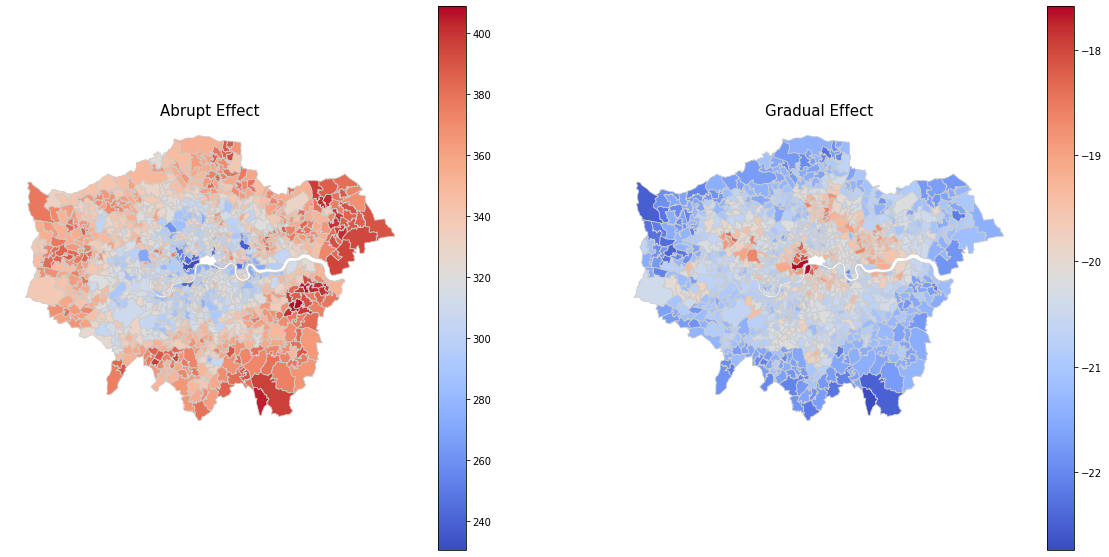

In [15]:
# Plot map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Abrupt effect
map_data.plot(column='abrupt_effect', cmap='coolwarm', linewidth=0.8, ax=ax[0], edgecolor='0.8', legend=True)
ax[0].set_title(f'Abrupt Effect', fontsize=15)
ax[0].axis('off')

# Gradual effect
map_data.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=ax[1], edgecolor='0.8', legend=True)
ax[1].set_title(f'Gradual Effect', fontsize=15)
ax[1].axis('off')

plt.show()

## Plot Maps

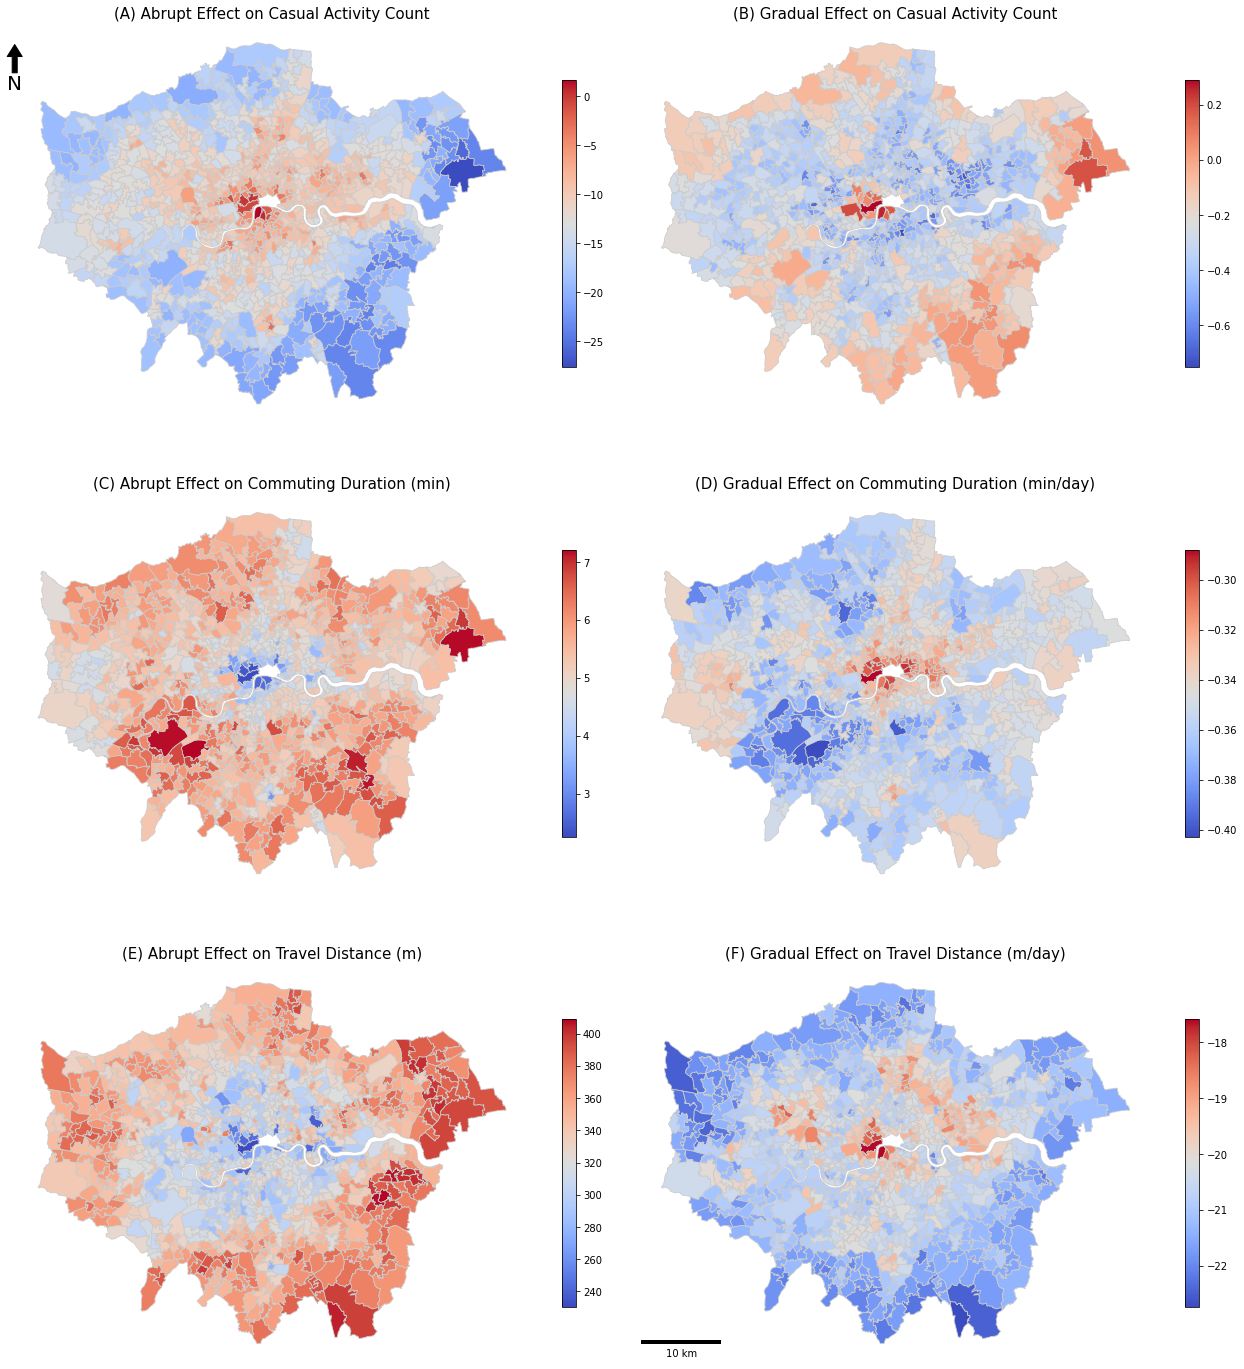

In [18]:
# Plot six maps
# read data
data1 = gpd.read_file('results/Casual Activity Count MSOA.geojson')
data2 = gpd.read_file('results/Commuting Duration MSOA.geojson')
data3 = gpd.read_file('results/Travel Distance MSOA.geojson')

# plot
fig, ax = plt.subplots(3, 2, figsize=(18, 20))
legend_kwds={'shrink': 0.6}  # Shrink and position legend  #'anchor': (0, 0)

# Casual Activity Count
data1.plot(column='abrupt_effect', cmap='coolwarm', linewidth=0.8, ax=ax[0, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[0, 0].set_title(f'(A) Abrupt Effect on Casual Activity Count', fontsize=15)
ax[0, 0].axis('off')
data1.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=ax[0, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[0, 1].set_title(f'(B) Gradual Effect on Casual Activity Count', fontsize=15)
ax[0, 1].axis('off')

# Commuting Duration
data2.plot(column='abrupt_effect', cmap='coolwarm', linewidth=0.8, ax=ax[1, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[1, 0].set_title(f'(C) Abrupt Effect on Commuting Duration (min)', fontsize=15)
ax[1, 0].axis('off')
data2.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=ax[1, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[1, 1].set_title(f'(D) Gradual Effect on Commuting Duration (min/day)', fontsize=15)
ax[1, 1].axis('off')

# Travel Distance
data3.plot(column='abrupt_effect', cmap='coolwarm', linewidth=0.8, ax=ax[2, 0], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[2, 0].set_title(f'(E) Abrupt Effect on Travel Distance (m)', fontsize=15)
ax[2, 0].axis('off')
data3.plot(column='gradual_effect', cmap='coolwarm', linewidth=0.8, ax=ax[2, 1], edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax[2, 1].set_title(f'(F) Gradual Effect on Travel Distance (m/day)', fontsize=15)
ax[2, 1].axis('off')

# Add Compass
x, y, arrow_length = 0, 0.95, 0.1
ax[0, 0].annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax[0, 0].transAxes)

# Add scale bar
scale = ScaleBar(
    dx=1,
    location="lower left",  # in relation to the whole plot
    scale_loc="bottom",  # in relation to the line
)
ax[2, 1].add_artist(scale)

plt.tight_layout()
plt.show()
fig.savefig('results/Figure3.png')